In [53]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from math import sqrt, fabs, log
import pandas as pd
import SimTools



# Plot angular resolution versus fit length for specified Gas / Energy

In [54]:
#Load simulated electon angular resolution dat
df = pd.read_pickle("./MS_diff_testing_data.pk")

# here we impose sigma < 18 deg
# The 15 degree small angle is only meant for the MS treatment
df_test = df.loc[df.sigma < 18.0].reset_index(drop=True)
df_test.head()


,gas,energy,fit_length,ang_dist,sigma,sigma_err
0,he_co2,40,0.3,"[0.09565008108864512, 0.019966152443957632, 0....",17.290324,0.439907
1,he_co2,40,0.4,"[-0.02246158029892831, 0.055917632933756546, 0...",16.736018,0.422247
2,he_co2,50,0.3,"[0.2717915705146363, -0.007327414557466363, -0...",14.137019,0.360731
3,he_co2,50,0.4,"[0.24759604896089454, -0.06393891271361678, 0....",12.944192,0.307977
4,he_co2,50,0.5,"[0.30393779244236435, -0.13034005472204843, 0....",13.806869,0.331136


In [55]:
# Load dNDx data
df_dNdx = pd.read_pickle("dNdx_data.pk")
df_dNdx.head()

,gas,energy,dNdx,dNdx_err,energy_loss
0,he_co2,30,55.256648,0.191932,0.972517
1,he_co2,40,39.943510,0.163184,0.703006
2,he_co2,50,30.810596,0.143319,0.542266
3,he_co2,60,26.391711,0.132644,0.464494
4,he_co2,70,22.472663,0.122400,0.395519


In [56]:
# Read dEdx data from https://physics.nist.gov/PhysRefData/Star/Text/ESTAR.html
# In HeCO2_dEdx.csv I used the mean excitation energy from degrad (30.4 eV)
# In HeCO2_dEdx2.csv I used the mean excitation energy from Estar (77.9 eV)
# If I use Estar data, using the Estar dEdx appears best
df_dEdx_co2 =pd.read_csv("HeCO2_dEdx2.csv")

# Convert energy to keV
df_dEdx_co2["energy"] = df_dEdx_co2.Energy*1000

# Add gas name
df_dEdx_co2["gas"] = 'he_co2'

# Convert stopping powers to dNdx [1/cm]
# 77.9 is the mean excitation energy from ESTAR
df_dEdx_co2["dNdx"] = df_dEdx_co2.Collision*1000000*0.000719/77.9

df_dEdx_co2

,Energy,Collision,Radiative,Total,energy,gas,dNdx
0,0.0100,20.20,0.00345,20.2,10.0,he_co2,186.441592
1,0.0125,17.00,0.00347,17.0,12.5,he_co2,156.906290
2,0.0150,14.70,0.00348,14.7,15.0,he_co2,135.677792
3,0.0175,13.10,0.00349,13.1,17.5,he_co2,120.910141
4,0.0200,11.80,0.00350,11.8,20.0,he_co2,108.911425
...,...,...,...,...,...,...,...
76,600.0000,2.66,14.20000,16.8,600000.0,he_co2,24.551220
77,700.0000,2.68,16.60000,19.3,700000.0,he_co2,24.735815
78,800.0000,2.69,19.00000,21.7,800000.0,he_co2,24.828113
79,900.0000,2.70,21.50000,24.2,900000.0,he_co2,24.920411


In [57]:
# Read dEdx data from https://physics.nist.gov/PhysRefData/Star/Text/ESTAR.html
df_dEdx_cf4 =pd.read_csv("HeCF4_dEdx.csv")

# Convert energy to keV
df_dEdx_cf4["energy"] = df_dEdx_cf4.Energy*1000

# Add gas name
df_dEdx_cf4["gas"] = 'he_cf4'

# Convert stopping powers to dNdx [1/cm]
# 35.2 is the mean excitation energy from degrad
df_dEdx_cf4["dNdx"] = df_dEdx_cf4.Collision*1000000*0.000719/35.2

df_dEdx_cf4

,Energy,Collision,Radiative,Total,energy,gas,dNdx
0,0.0100,22.90,0.00421,22.9,10.0,he_cf4,467.758523
1,0.0125,19.20,0.00425,19.2,12.5,he_cf4,392.181818
2,0.0150,16.50,0.00427,16.6,15.0,he_cf4,337.031250
3,0.0175,14.60,0.00429,14.6,17.5,he_cf4,298.221591
4,0.0200,13.10,0.00430,13.2,20.0,he_cf4,267.582386
...,...,...,...,...,...,...,...
76,600.0000,2.48,16.40000,18.9,600000.0,he_cf4,50.656818
77,700.0000,2.49,19.20000,21.7,700000.0,he_cf4,50.861080
78,800.0000,2.50,22.00000,24.5,800000.0,he_cf4,51.065341
79,900.0000,2.51,24.80000,27.3,900000.0,he_cf4,51.269602


In [58]:
df_dEdx = pd.concat([df_dEdx_co2,df_dEdx_cf4], ignore_index=True)
df_dEdx

,Energy,Collision,Radiative,Total,energy,gas,dNdx
0,0.0100,20.20,0.00345,20.2,10.0,he_co2,186.441592
1,0.0125,17.00,0.00347,17.0,12.5,he_co2,156.906290
2,0.0150,14.70,0.00348,14.7,15.0,he_co2,135.677792
3,0.0175,13.10,0.00349,13.1,17.5,he_co2,120.910141
4,0.0200,11.80,0.00350,11.8,20.0,he_co2,108.911425
...,...,...,...,...,...,...,...
157,600.0000,2.48,16.40000,18.9,600000.0,he_cf4,50.656818
158,700.0000,2.49,19.20000,21.7,700000.0,he_cf4,50.861080
159,800.0000,2.50,22.00000,24.5,800000.0,he_cf4,51.065341
160,900.0000,2.51,24.80000,27.3,900000.0,he_cf4,51.269602


In [59]:
df_dNdx = df_dNdx.merge(df_dEdx,left_on=['gas','energy'],right_on=['gas','energy'])
df_dNdx

,gas,energy,dNdx_x,dNdx_err,energy_loss,Energy,Collision,Radiative,Total,dNdx_y
0,he_co2,30,55.256648,0.191932,0.972517,0.03,8.64,0.00352,8.64,79.745315
1,he_co2,40,39.943510,0.163184,0.703006,0.04,6.96,0.00354,6.97,64.239281
2,he_co2,50,30.810596,0.143319,0.542266,0.05,5.91,0.00356,5.92,54.548010
3,he_co2,60,26.391711,0.132644,0.464494,0.06,5.19,0.00359,5.19,47.902567
4,he_co2,70,22.472663,0.122400,0.395519,0.07,4.66,0.00362,4.67,43.010783
5,he_co2,80,20.071210,0.115675,0.353253,0.08,4.26,0.00366,4.27,39.318870
6,he_co2,90,17.803752,0.108946,0.313346,0.09,3.94,0.00370,3.95,36.365340
7,he_co2,100,16.847419,0.105979,0.296515,0.10,3.69,0.00374,3.69,34.057895
8,he_co2,150,12.527643,0.091388,0.220487,0.15,2.90,0.00398,2.91,26.766367
9,he_co2,200,10.898856,0.085240,0.191820,0.20,2.50,0.00425,2.51,23.074454


In [80]:
# Select Gas
mixture = SimTools.he_co2

# Select Energy [keV]
Energy = 100 

# Select range of fit lengths to plot [cm]
fit_len_min = 0.2
fit_len_max = 1.5

In [84]:
# Select drift length [cm], our test cases are 25 cm for He:CF4 and 10 cm for He:CO2
if mixture["name"] == 'he_co2':
    drift = 10.0
elif mixture["name"] == 'he_cf4':
    drift = 25.0
else:
    print("Error: select valid gas mixture")

# Get Rossi fit parameter
S_2 = SimTools.rossi_fit_params["S_2"]
# Get uncertainty on Rossi fit parameter
S_2_sigma = SimTools.S2_std

# Get dNdx value [1/cm]
dNdx = df_dNdx.loc[ (df_dNdx.gas == mixture["name"]) & (df_dNdx.energy == Energy) ]['dNdx_y'].item()

# Get Radiation Length [m]
Rad_L = SimTools.Rad_Lengths[mixture["name"]]

# Get sigma for diffusion
if ('overide_sigma' in list(mixture)):
    sigma =  mixture['overide_sigma']
else:
    sigma_r = mixture['sigma_r']
    sigma_T = mixture['sigma_T']
    sigma = sqrt( sigma_r**2 + (sqrt(drift) * sigma_T )**2 )


# Find analytical extimation of the optimal fit length [m]
opt_L = SimTools.Opt_len( (Energy/1000.0, Rad_L), S_2, sigma, dNdx)

# Make selection on simulation data
df_cut=df_test.loc[ (df_test.gas==mixture["name"]) & (df_test.energy==Energy )  ].reset_index(drop=True)
df_cut

,gas,energy,fit_length,ang_dist,sigma,sigma_err
0,he_co2,100,0.3,"[0.13821604408554078, 0.009641627658663115, -0...",15.104823,0.380635
1,he_co2,100,0.4,"[0.1206504150962912, -0.04307467821255837, -0....",10.024758,0.245993
2,he_co2,100,0.5,"[0.16947300279913943, -0.05210272752630705, -0...",8.857268,0.206712
3,he_co2,100,0.6,"[0.16569546938655608, 0.00044251693700108247, ...",8.604973,0.209339
4,he_co2,100,0.7,"[0.20960236261443166, -0.023086793744721334, -...",8.800438,0.221385
5,he_co2,100,0.8,"[0.2216692937239651, -0.04485406601704892, -0....",9.209882,0.232108
6,he_co2,100,0.9,"[0.27138364071466525, -0.08469879140010322, -0...",9.945215,0.252122


In [85]:
x_vals = np.arange(fit_len_min,fit_len_max,0.0001)

MS_contrib = []
MS_contrib_H = []
MS_contrib_L = []
PR_contrib = []

for x_val in x_vals:

    MS_contrib += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2) ]
    MS_contrib_H += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2+S_2_sigma) ]
    MS_contrib_L += [ SimTools.rossi_fit( (Energy/1000.0, x_val/100.0, Rad_L) , S_2-S_2_sigma) ]

    PR_contrib += [ SimTools.Point_Res(x_val/100.0, dNdx, sigma) ]


MS_contrib = np.array(MS_contrib)
MS_contrib_H = np.array(MS_contrib_H)
MS_contrib_L = np.array(MS_contrib_L)
PR_contrib = np.array(PR_contrib)


Text(0, 0.5, '$ \\sigma^{\\rm plane}_{\\psi, \\rm{total} } $')

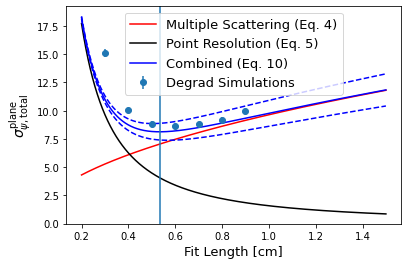

In [86]:
# Plot Simulation data
plt.errorbar(df_cut.fit_length , df_cut.sigma, yerr=df_cut.sigma_err, fmt='o',  label='Degrad Simulations')

# Plot MS and PR contributions
plt.plot(x_vals, MS_contrib, 'r-', label='Multiple Scattering (Eq. 4)')
plt.plot(x_vals, PR_contrib, 'k-', label='Point Resolution (Eq. 5)')

# Plot total point resolution with uncertainty on S_2
plt.plot(x_vals, np.sqrt(MS_contrib**2+PR_contrib**2), 'b-', label='Combined (Eq. 10)')
plt.plot(x_vals, np.sqrt(MS_contrib_H**2+PR_contrib**2), 'b--')
plt.plot(x_vals, np.sqrt(MS_contrib_L**2+PR_contrib**2), 'b--')

# Plot predicted optimal fit length
plt.axvline(opt_L*100)


plt.legend( fontsize = 13)
plt.xlabel("Fit Length [cm]", fontsize = 13)
plt.ylabel("$ \sigma^{\\rm plane}_{\psi, \\rm{total} } $", fontsize = 14)
#plt.savefig("../figures/sigma_vs_x.pdf")



# Plot best predicted vs best Simulated angular resolution for all test gases / energies

In [14]:
# Get Rossi fit parameter
S_2 = SimTools.rossi_fit_params["S_2"]
# Get uncertainty on Rossi fit parameter
S_2_sigma = SimTools.S2_std

# Function returning the point resolution given a gas mixture name
def get_sigma_x(gas_name):

    if gas_name == 'he_co2':
        drift = 10.0
        mixture = SimTools.he_co2

    elif gas_name == 'he_cf4':
        drift = 25.0
        mixture = SimTools.he_cf4
    else:
        print("Error: select valid gas mixture")

    # Get sigma for diffusion
    if ('overide_sigma' in list(mixture)):
        sigma =  mixture['overide_sigma']
    else:
        sigma_r = mixture['sigma_r']
        sigma_T = mixture['sigma_T']
        sigma = sqrt( sigma_r**2 + (sqrt(drift) * sigma_T )**2 )

    return sigma 



In [15]:
#Load simulated electon angular resolution data that has higher segmentation in x
df = pd.read_pickle("./MS_diff_testing_data_fine.pk")

# Keep only the energy range of interest for both gases
df_test2 = df.loc[ ((df.gas == 'he_co2') & (df.energy >= 50)) | ((df.gas == 'he_cf4') & (df.energy >= 70) ) ].reset_index(drop=True)
df_test2["fit_length"] = np.round(df_test2.fit_length,2)

In [20]:
# Group by gas and energy then find the index of the fit length with the smallest sigma
indices = np.array(df_test2.groupby(['gas','energy'])['sigma'].idxmin())

# Select rows corresponding to lowest sigma in each gas / energy group from original df
df_best_sim = df_test2.iloc[indices].reset_index(drop=True)

# add a column with the point resolution for each gas mixture
df_best_sim['sigma_x']=df_best_sim.gas.apply(get_sigma_x)

# Add column with optimal fit length [m]
df_best_sim['x_o'] = df_best_sim.apply(lambda row: SimTools.Opt_len( (row.energy/1000.0, SimTools.Rad_Lengths[row.gas]), S_2, row.sigma_x, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx_x'].item()) , axis = 1)

# Add a column with the predict best angular resolution
df_best_sim['sigma_pred'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)
df_best_sim['sigma_pred_err_H'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2+S_2_sigma)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)
df_best_sim['sigma_pred_err_L'] = df_best_sim.apply(lambda row: np.sqrt(SimTools.rossi_fit( (row.energy/1000.0, row.x_o, SimTools.Rad_Lengths[row.gas]) , S_2-S_2_sigma)**2 + SimTools.Point_Res(row.x_o, df_dNdx.loc[ (df_dNdx.gas == row.gas) & (df_dNdx.energy == row.energy) ]['dNdx'].item(), row.sigma_x)**2)  , axis = 1)

# Get the simulated angular resolution at x_o
df_best_sim['sigma_xo'] = df_best_sim.apply(lambda row: df_test2.loc[ (df_test2.gas == row.gas) & (df_test2.energy == row.energy ) & (df_test2.fit_length == round(row.x_o*100,2))  ].sigma.item()  , axis = 1)
df_best_sim['sigma_xo_err'] = df_best_sim.apply(lambda row: df_test2.loc[ (df_test2.gas == row.gas) & (df_test2.energy == row.energy ) & (df_test2.fit_length == round(row.x_o*100,2))  ].sigma_err.item()  , axis = 1)


df_best_sim


KeyError: 'dNdx_x'

(45.0, 200.0)

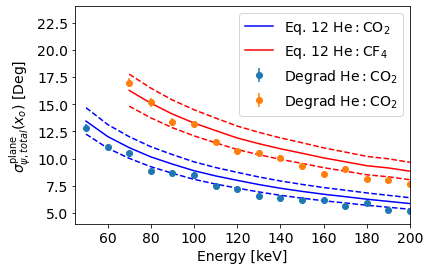

In [31]:
# Make Plot the best simulated sigma 
# this method has bias, selects data points with uncertainty below true ang res


# Plot He:CO2 result
df_he_co2 = df_best_sim.loc[df_best_sim.gas == "he_co2"]


plt.errorbar(df_he_co2.energy, df_he_co2.sigma, yerr=df_he_co2.sigma_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred,'b-',label='Eq. 12 $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_H,'b--')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_L,'b--')


# Plot He:CF4 result
df_he_cf4 = df_best_sim.loc[df_best_sim.gas == "he_cf4"]

plt.errorbar(df_he_cf4.energy, df_he_cf4.sigma, yerr=df_he_cf4.sigma_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred,'r-',label='Eq. 12 $ { \\rm He} : {\\rm CF}_4$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_H,'r--')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_L,'r--')


plt.legend(loc='upper right',fontsize=14)

plt.xlabel("Energy [keV]",fontsize=14)
plt.ylabel("$\\sigma_{\\psi , total}^{\\rm plane} (x_o)$ [Deg]",fontsize=14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylim(4,24)
plt.xlim(45,200)



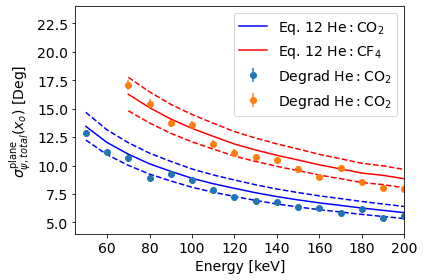

In [30]:
# Plot the simulated sigma at x_o


# Plot He:CO2 result
df_he_co2 = df_best_sim.loc[df_best_sim.gas == "he_co2"]


plt.errorbar(df_he_co2.energy, df_he_co2.sigma_xo, yerr=df_he_co2.sigma_xo_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred,'b-',label='Eq. 12 $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_H,'b--')
plt.plot(df_he_co2.energy,df_he_co2.sigma_pred_err_L,'b--')


# Plot He:CF4 result
df_he_cf4 = df_best_sim.loc[df_best_sim.gas == "he_cf4"]

plt.errorbar(df_he_cf4.energy, df_he_cf4.sigma_xo, yerr=df_he_cf4.sigma_xo_err, fmt='o',  label='Degrad $ { \\rm He} : {\\rm CO}_2$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred,'r-',label='Eq. 12 $ { \\rm He} : {\\rm CF}_4$')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_H,'r--')
plt.plot(df_he_cf4.energy, df_he_cf4.sigma_pred_err_L,'r--')


plt.legend(loc='upper right',fontsize=14)

plt.xlabel("Energy [keV]",fontsize=14)
plt.ylabel("$\\sigma_{\\psi , total}^{\\rm plane} (x_o)$ [Deg]",fontsize=14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylim(4,24)
plt.xlim(45,200)
plt.tight_layout()
#plt.savefig("../figures/best_ang_res.pdf")



In [38]:
print("Mean residual [Deg.]: ", np.mean(np.abs((df_best_sim.sigma_xo - df_best_sim.sigma_pred))))

Mean residual [Deg.]:  0.5894105303691276
